In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

**Class: OU processes**

In [2]:
class OU:
    def __init__(self, t0, t1, z0, alpha, beta, sigma):
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.pts = torch.sort(torch.cat([torch.DoubleTensor(100).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0]
        self.trj, self.dt = self.simulate()
        
    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
        """
        output = np.empty(len(self.pts))
        output[0] = self.z0
        interval = self.pts[1:] - self.pts[:-1]
        for t in range(1, len(self.pts)):
            
            # if the distance is too small, variance becomes 0
            dt = interval[t-1]
            
            mean = self.alpha + (output[t-1] - self.alpha) * np.exp(-1 * self.beta * dt)
            var = np.sqrt((self.sigma ** 2) * (1 - np.exp(-2 * self.beta * dt)) / (2 * self.beta))
            assert var > 0, "variance is negative, var:%.3f interval: %.3f" % (var, dt)
            output[t] = ss.norm.rvs(loc = mean, scale = var)
        return torch.from_numpy(output), interval

Variational inference: KL

In [22]:
class ELBO:

    """
        Given a simulated variational process, compute the gradient of the ELBO. 
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha, self.beta, self.sigma = torch.tensor([ou.alpha, ou.beta, ou.sigma])
        
    def KL_ito(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma = self.alpha, self.beta, self.sigma

        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
        func_kl = vmap(lambda z: z ** 2)

        return -1 * ((beta ** 2) - 1) / 2 * torch.trapezoid(abs(func_kl(self.ou.trj)), x=self.ou.pts)
    
    def KL_rest(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma = self.alpha, self.beta, self.sigma
        z0 = self.ou.z0
        z1 = self.ou.trj[-1]
        t0 = self.ou.t0
        t1 = self.ou.t1
        
        # Obtain the rest 
        term1 = - ((beta - 1)/2) * (t1-t0)
    
        def A(u):
            return ((beta - 1) / 2) * ((t1 ** 2) - (t0 ** 2))
        
        term2 = -1 / (sigma ** 2) * (A(z1) - A(z0))

        return term1 + term2
    
    def log_prob(self, obs):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
        """
        def log_pdf(obs, z):
            return ss.norm.logpdf(obs, loc=z, scale=.01)
            
        
        return log_pdf(obs, self.ou.trj[-1])


In [30]:
class Score:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        alpha, beta = Variable(torch.tensor([self.ou.alpha, self.ou.beta]), requires_grad=True)
        sigma = torch.tensor(self.ou.sigma)
        dt = self.ou.dt
        X = self.ou.trj
        
        def compute_transition(X, dt, alpha, beta, sigma):
            """
            Compute the transition density of the (simulated) path
            """
            term1 = -1/2 * (2 * torch.log(sigma) - torch.log(beta) + torch.log(1 - torch.exp(-2 * beta * dt)))
            term2 = -1 * beta * (X[1:] - alpha - (X[:-1] - alpha) * torch.exp(-1 * beta * dt)) ** 2 
            term3 = (sigma ** 2) * (1 - torch.exp(-2 * beta * dt))

            return torch.sum(term1 + term2/term3)
        
        NLL = compute_transition(X, dt, alpha, beta, sigma)
        
        beta.retain_grad()
        
        NLL.backward()
        
        
#         return {'beta':beta.grad}
        return {'beta':beta.grad}
#         return self.beta.grad

**Generate observations from Gaussian likelihood**

Noisy Observations from the SDE:

$dX_{t} = -X_{t}dt + \sigma dW_{t}$

In [53]:
true_sde = OU(t0 = 0, t1 = 10., z0 = 2., alpha = 0, beta = 1., sigma = 1.)

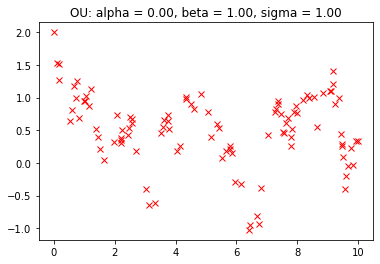

In [54]:
plt.plot(true_sde.pts, true_sde.trj, 'rx')
plt.title("OU: alpha = %.2f" % vi.alpha + ", beta = %.2f" % vi.beta + ", sigma = %.2f" % vi.sigma)
plt.show()

In [55]:
obs = np.random.normal(loc = true_sde.trj[::10], scale = .01)

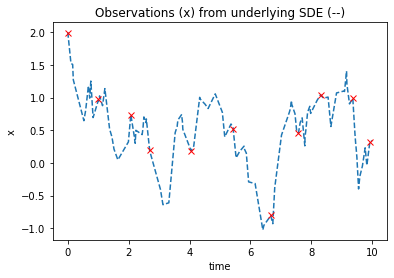

In [56]:
plt.title("Observations (x) from underlying SDE (--)")
plt.plot(true_sde.pts, true_sde.trj, '--')
plt.plot(true_sde.pts[::10], obs, 'rx')
plt.xlabel("time")
plt.ylabel("x")
plt.show()

**Variational inference**

In [35]:
import tqdm as tq

In [ ]:
beta_ = 3.

N = 100
learning_rate = 0.0002

trace = []
for i in tq.tqdm(range(300)):
# for i in range(300):
    beta_grad = 0.

    for i in range(N):
        vi = OU(t0 = 0., t1 = 1., z0 = obs[0], alpha = 0 , beta = beta_ , sigma = 1.)
        elbo = ELBO(vi)
        score = Score(vi)
        
        scores = score.compute_score()
        f_of_X = -1 * (elbo.log_prob(obs[1]) - (elbo.KL_ito() + elbo.KL_rest()))
        assert f_of_X != np.nan, "shit"

        beta_grad += f_of_X * scores['beta']
        
    beta_ -= learning_rate * beta_grad/N

#     print("beta = ", beta_)
    trace.append(beta_.data.cpu().numpy().copy())
# score.compute_score()

 37%|█████████████████▊                              | 111/300 [01:46<03:07,  1.01it/s]

In [ ]:
for i in range(10):
    posterior = OU(t0 = 0., t1 = 1., z0 = obs[0], alpha = 0 , beta = beta_ , sigma = 1.)
    plt.plot(posterior.pts, posterior.trj, 'b')
    plt.plot(obs, 'rx')
plt.plot(true_sde.pts,true_sde.trj, 'grey', linestyle='dashed')

In [ ]:
for i in range(50):
    posterior = OU(t0 = 0., t1 = 1., z0 = obs[0], alpha = 0, beta = beta_, sigma = 1.)
    plt.plot(posterior.pts, posterior.trj, 'b')
    plt.plot(obs[:2], 'rx')
plt.plot(vi.pts,vi.trj, 'grey', linestyle='dashed')

**Trace plot: gradient**

In [ ]:
plt.title("Trace plot: beta")
plt.plot(np.arange(len(trace)), trace)
plt.xlabel("iteration")
plt.ylabel(r"$\beta$")

In [ ]:
alpha_, beta_, obs[0]

In [ ]:
# observations at t1 vs posterior mean at t1
obs[1], alpha_ + (torch.from_numpy(obs[0]) - alpha_)*torch.exp(-1 * beta_ * 1)

In [ ]:
def posterior_moment(init, alpha, beta):
    pts = np.linspace(0,1,100)
    dt = pts[1:] - pts[:-1]
    
    mean = [init]
        
    for i in range(dt.shape[0]):
        mean.append(alpha + (mean[i] - alpha)*np.exp(-1 * beta * dt[i]))
    
    func = lambda t: np.sqrt((alpha ** 2 / (2*beta)) * (1 - np.exp(-2 * beta * t)))
    sd = list(map(func, dt))
    
    return np.array(mean), np.array(sd)

In [ ]:
pmean, psd = posterior_moment(obs[0][0], alpha_.data.numpy(), beta_.data.numpy())

In [ ]:
plt.plot(t[:100], X[:100])
plt.plot(t[:100], pmean)
# plt.fill_between(t[1:100], pmean[1:] - psd, pmean[1:] + psd)

In [ ]:
plt.plot(t[:100], pmean)
plt.plot(obs[:2], 'rx')